# I. Initial preparation

read data, quick eda 

Note: data process functions are built afterwards

In [1]:

from bike_demand_utils import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_profiling as pp
from datetime import datetime
from xgboost import XGBRegressor
import seaborn as sn
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
import collections
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train = pd.read_csv('train.csv')
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [3]:
# How to call data processing function

train_processed = data_process(train).complete_wrangling()
train_processed.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,is_workday_morning_peak,is_workday_afternoon_peak,is_workday_night_time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,...,0,0,0,1,0,0,0,0,0,0


In [4]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
train.shape

(10886, 12)

In [6]:
test = pd.read_csv('test.csv')
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [7]:
test.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [8]:
#profile = pp.ProfileReport(train, title="Pandas Profiling Report")
#profile.to_file("bike_pp_20220822.html")

## 1.1 Pandas Profiling Quick EDA Results

#### 1.1.1 Missing Values

Only 1 row

#### 1.1.2 correlation

Casual & registered and count are highly correlated, but only exist in training data, not in test data, which will lead to data leakage if used as explanatory variables. Therefore it needs to be deleted.

There is a high correlation between wind speed and season and humidity.


#### 1.1.3 Anomaly distribution

Windspeed = 0 occurs more frequently

weather = 4 (extreme weather such as heavy rain and snow) only occurs once

The frequency of holiday is only 3%


## 1.2 Data Wrangling

In [9]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [10]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [11]:
train = train[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed','count']]
# Select the field where test data has appeared
train['is_train'] = 1
test['is_train'] = 0
data = train.append(test).reset_index(drop = True)
data[data['is_train']== 1].tail()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,is_train
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336.0,1
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241.0,1
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168.0,1
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129.0,1
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,88.0,1


In [12]:
data['season_desc'] = data['season'].apply(lambda x: mutate_season(x))
data['weather_desc'] = data['weather'].apply(lambda x: mutate_weather(x))
data.tail()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,is_train,season_desc,weather_desc
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,0,Spring,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe..."
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,0,Spring,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe..."
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy"
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy"
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy"


In [13]:
data['weekday'] = data['datetime'].apply(lambda x: mutate_workday(x))
data['hour'] = data['datetime'].apply(lambda x: mutate_hour(x))
data['month'] = data['datetime'].apply(lambda x:mutate_month(x))
data['day'] = data['datetime'].apply(lambda x:mutate_day(x))
data['year'] = data['datetime'].apply(lambda x:mutate_year(x))
data.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,is_train,season_desc,weather_desc,weekday,hour,month,day,year
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,0,Spring,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",Monday,19,12,31,2012
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,0,Spring,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",Monday,20,12,31,2012
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy",Monday,21,12,31,2012
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy",Monday,22,12,31,2012
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,0,Spring,"Clear, Few clouds, Partly cloudy, Partly cloudy",Monday,23,12,31,2012


## 1.3 Process Data Types

In [14]:
data.dtypes

datetime         object
season            int64
holiday           int64
workingday        int64
weather           int64
temp            float64
atemp           float64
humidity          int64
windspeed       float64
count           float64
is_train          int64
season_desc      object
weather_desc     object
weekday          object
hour              int64
month             int64
day               int64
year              int64
dtype: object

In [15]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'is_train', 'season_desc',
       'weather_desc', 'weekday', 'hour', 'month', 'day', 'year'],
      dtype='object')

In [16]:
categorical_variables = ['season', 'weather', 'weekday']#, 'hour', 'month']
numerical_variables = ['temp', 'atemp', 'humidity', 'windspeed']
for c in categorical_variables:
    data[c] = data[c].astype('object')
for n in numerical_variables:
    data[n] = data[n].astype('float64')
data.dtypes

datetime         object
season           object
holiday           int64
workingday        int64
weather          object
temp            float64
atemp           float64
humidity        float64
windspeed       float64
count           float64
is_train          int64
season_desc      object
weather_desc     object
weekday          object
hour              int64
month             int64
day               int64
year              int64
dtype: object

---

# II. EDA
use plots to visualize distribution and have a basic understanding of what could be possible strong indicators and what could be done to improve outcome

[Text(0.5, 0, 'Weather'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Weather')]

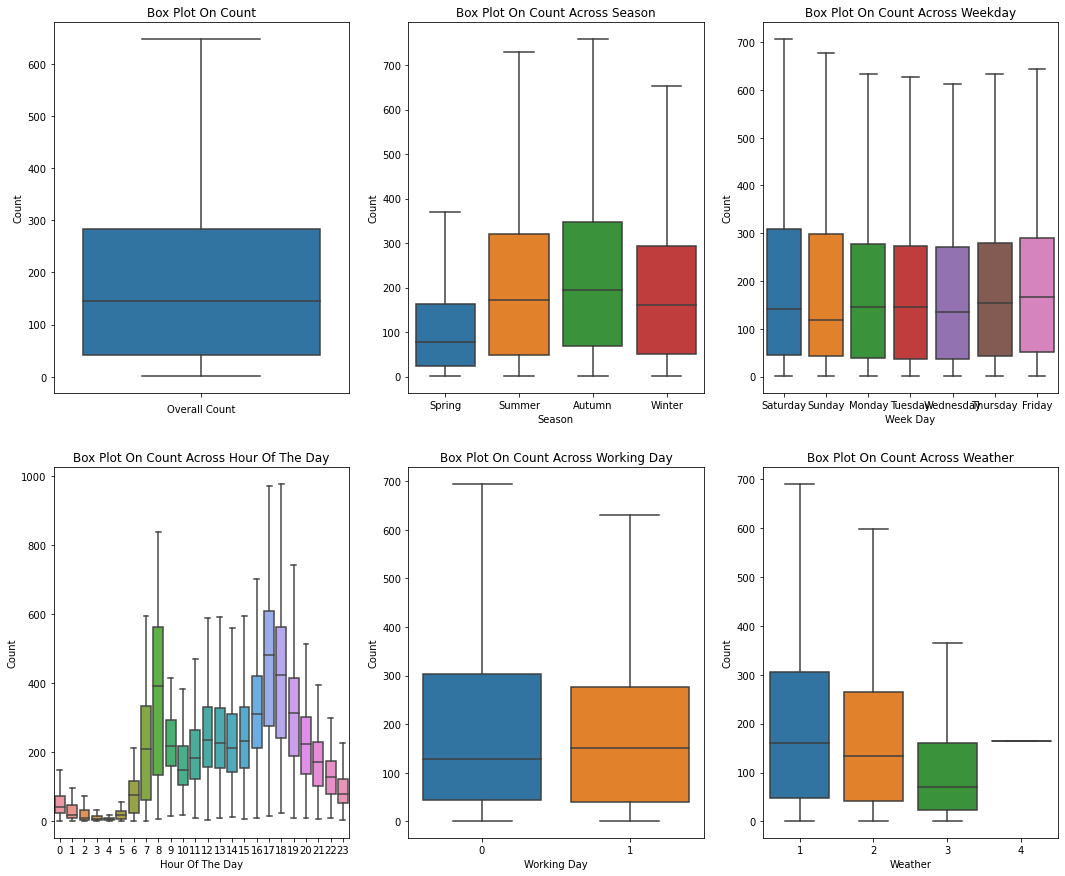

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18, 15)
sn.boxplot(data=data,y="count",orient="v",ax=axes[0][0],showfliers = False)
sn.boxplot(data=data,y="count",x="season_desc",orient="v",ax=axes[0][1],showfliers = False)
sn.boxplot(data=data,y="count",x="hour",orient="v",ax=axes[1][0],showfliers = False)
sn.boxplot(data=data,y="count",x="workingday",orient="v",ax=axes[1][1],showfliers = False)
sn.boxplot(data=data,y='count',x='weekday',orient = 'v', ax = axes[0][2],showfliers = False)
sn.boxplot(data=data,y='count',x='weather',orient = 'v', ax = axes[1][2],showfliers = False)

axes[0][0].set(xlabel = 'Overall Count',ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[0][2].set(xlabel = 'Week Day', ylabel = 'Count', title = 'Box Plot On Count Across Weekday')
axes[1][2].set(xlabel = 'Weather', ylabel = 'Count', title = 'Box Plot On Count Across Weather')

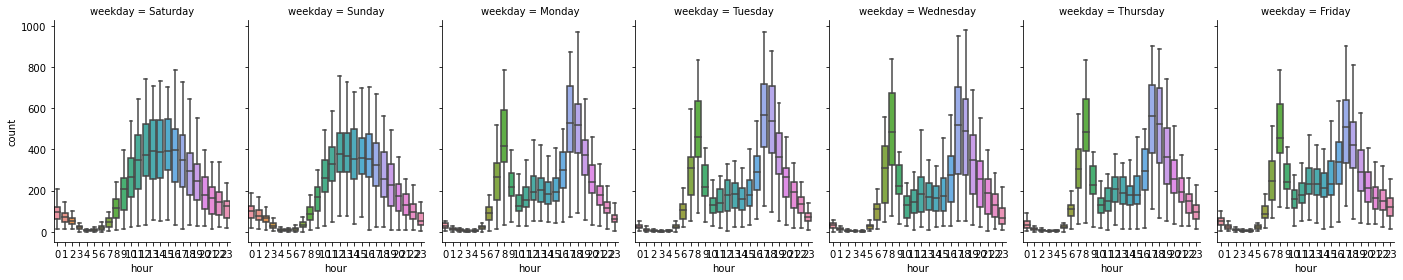

In [18]:
# combining different features together and check difference
sn.catplot(x="hour", 
           y="count",
           #hue="season",
           col="weekday",
           data=data, 
           kind="box",
           height=4,
           aspect=.7,
           showfliers = False)

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count across hour & weekday')]

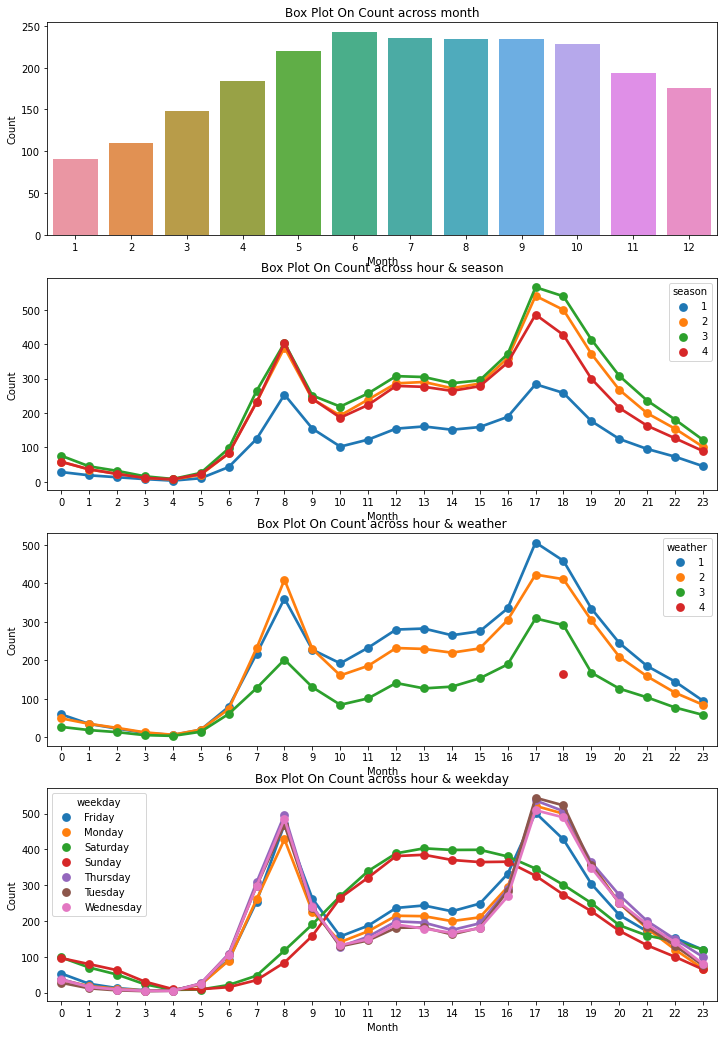

In [19]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 18)

# count over month
month_count = pd.DataFrame(data.groupby("month")["count"].mean()).reset_index()

sn.barplot(x=month_count['month'],
           y=month_count['count'],
           ax = ax1)

ax1.set(xlabel = 'Month',ylabel='Count', title="Box Plot On Count across month")

# count over hour / season
hour_season_count = pd.DataFrame(data.groupby(['hour','season'])["count"].mean()).reset_index()

sn.pointplot(x=hour_season_count['hour'],
           y=hour_season_count['count'],
           hue = hour_season_count['season'],
           ax = ax2)

ax2.set(xlabel = 'Month',ylabel='Count', title="Box Plot On Count across hour & season")

# count over hour / weather
hour_season_count = pd.DataFrame(data.groupby(['hour','weather'])["count"].mean()).reset_index()

sn.pointplot(x=hour_season_count['hour'],
           y=hour_season_count['count'],
           hue = hour_season_count['weather'],
           ax = ax3)

ax3.set(xlabel = 'Month',ylabel='Count', title="Box Plot On Count across hour & weather")

# count over hour / weekday
hour_season_count = pd.DataFrame(data.groupby(['hour','weekday'])["count"].mean()).reset_index()

sn.pointplot(x=hour_season_count['hour'],
           y=hour_season_count['count'],
           hue = hour_season_count['weekday'],
           ax = ax4)

ax4.set(xlabel = 'Month',ylabel='Count', title="Box Plot On Count across hour & weekday")


## 2.1 EDA Findings

Spring is slightly lower than the other three seasons, and autumn has the highest count average

The closer to the weekend the higher the count

The better the weather, the higher the count

Monday to Friday, 7-9 o'clock, 17-19 o'clock is the peak of the car use, and the weekend is more gentle => maybe you can increase the dummy variable is_weekday_peak_time

## 2.2 Predict Label Distribution Check

/Users/artefact/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1.,   1.,   1., ..., 968., 970., 977.])),
 (169.8294267323139, 191.5741319125482, 0.9372682766213172))

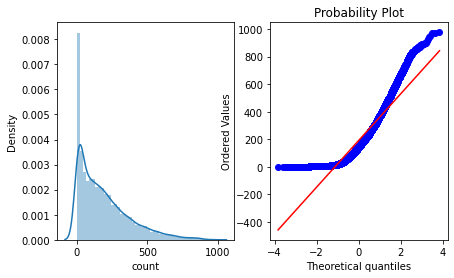

In [20]:
from scipy import stats

data_train = data[data['is_train']==1]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(7, 4)
sn.distplot(data_train["count"],ax=ax1)
stats.probplot(data_train["count"], dist='norm', fit=True, plot=ax2)

Count distribution is clearly left-skewed, indicating needs for log-transformation

Reference：https://www.kaggle.com/questions-and-answers/187759

/Users/artefact/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244172, 4.591363690454027, 0.9611793780126964))

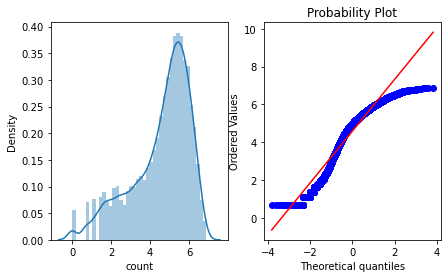

In [21]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(7, 4)
sn.distplot(np.log(data_train["count"]),ax=ax1)
stats.probplot(np.log1p(data_train["count"]), dist='norm', fit=True, plot=ax2)

/Users/artefact/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909614))

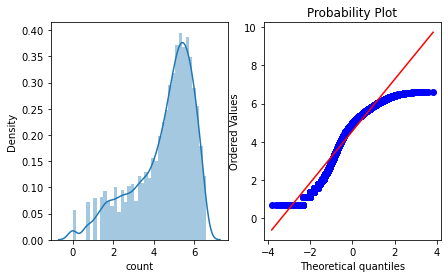

In [22]:
#Remove outliers that are 3 st away from mean
data_move_outliers = data_train[np.abs(data_train["count"]-data_train["count"].mean())<=(3*data_train["count"].std())] 

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(7, 4)
sn.distplot(np.log(data_move_outliers["count"]),ax=ax1)
stats.probplot(np.log1p(data_move_outliers["count"]), dist='norm', fit=True, plot=ax2)


---

# III. Modeling

Try to predict the number of car users per 1 hour period by label

v1: directly use the previous label to predict count

v2: For the part with windspeed = 0, use other labels to predict, and use the predicted value as a label to predict count

## 3.1 Feature Engineering

### 3.1.1 Convert Categorical

If cardinality <=4 then use one-hot dummy encoding, else use other ways

In [23]:
for c in categorical_variables:
    print('the cardinality of column', c, ' is ', str(data[c].nunique()))

the cardinality of column season  is  4
the cardinality of column weather  is  4
the cardinality of column weekday  is  7


In [24]:
# convert into dummy variables
one_hot_target = []
for c in categorical_variables:
    if (data[c].nunique() <= 4):
        one_hot_target.append(c)
one_hot_target

['season', 'weather']

In [25]:
for o in one_hot_target:
    new_column=pd.get_dummies(data[o],prefix=o)
    data = pd.concat([data, new_column], axis = 1)
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'is_train', 'season_desc',
       'weather_desc', 'weekday', 'hour', 'month', 'day', 'year', 'season_1',
       'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
       'weather_3', 'weather_4'],
      dtype='object')

#### High Cardinality Processing

hour:

    1. is_morning_peak （7 & 8, holiday = 0）
    
    2. is_afternoon_peak (17 & 18, holiday = 0)
    
    3. is_night_time (0-6, 22-24, holiday = 0)
    
weekday:

    1. is_work_day (Mon to Fri, holiday = 0)
    
    2. is_weekend (Sat & Sun)

In [26]:
data['is_workday_morning_peak'] = 0
data.loc[(data['hour'] >= 7) & (data['hour'] <= 8) & (data['holiday'] == 0), 'is_workday_morning_peak'] = 1

data['is_workday_afternoon_peak'] = 0
data.loc[(data['hour'] >= 17) & (data['hour'] <= 18) & (data['holiday'] == 0), 'is_workday_afternoon_peak'] = 1

data['is_workday_night_time'] = 0
data.loc[(data['hour'] >= 22) & (data['hour'] <= 6) & (data['holiday'] == 0), 'is_workday_night_time'] = 1

In [27]:
data_model = data[data['is_train'] == 1]
len(data_model)

10886

## 3.2 Split train + test

In [28]:
from sklearn.model_selection import train_test_split
X = data_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19960127)

<AxesSubplot:>

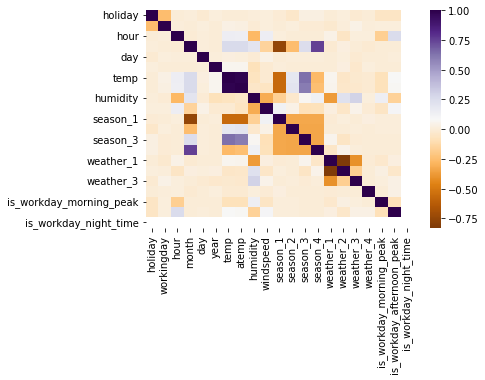

In [29]:
# correlation among explanatory variables
sn.heatmap(X.corr(),cmap='PuOr')

## 3.3 Regression Models

### 3.3.1 Regressor 1: Linear Regression Baseline - only numerical & dummy variables

In [30]:

reg_1 = linear_model.LinearRegression()
reg_1.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = list(reg_1.predict(X_test))
y_pred_refined = [p if p > 0 else 0 for p in y_pred]
cal_rmlse(y_test,y_pred_refined)

1.2098247638518056

### 3.3.2 Regressor 2: Linear Regression Baseline -  count log1p transformation，then use expm1 to transform back

Since the model is less likely to underestimate the count after the count log transform, the total rmlse is reduced from 1.3 to 1.09

In [32]:
y_log_transformed = np.log1p(data_model['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)

reg_2 = linear_model.LinearRegression()
reg_2.fit(X_train, y_train) 
y_pred = list(reg_2.predict(X_test))

y_pred_exp = np.expm1(y_pred)
y_real = np.expm1(y_test)
cal_rmlse(y_real,y_pred_exp)

0.8857214453628582

### 3.3.3 Same feature tested on regression models
RF, Adaboost, BaggingRegressor, SVR, KNN

In [33]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
y_real = np.expm1(y_test)
for model in range (len(models)):
    reg=models[model]
    reg.fit(X_train,y_train)
    pred_log=reg.predict(X_test)
    pred = np.expm1(pred_log)
    rmsle.append(cal_rmlse(pred,y_real))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
pd.DataFrame(d)

,Modelling Algo,RMSLE
0,RandomForestRegressor,0.317492
1,AdaBoostRegressor,0.630060
2,BaggingRegressor,0.336424
3,SVR,1.268821
4,KNeighborsRegressor,0.826723


RF and Bagging Regressor returns the lowest rmsle

### 3.3.4 Regressor 3: Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

reg_3 = RandomForestRegressor(random_state=19960127)
reg_3.fit(X_train, y_train) 
y_pred = list(reg_3.predict(X_test))

y_pred_exp = np.expm1(y_pred) 

y_real = np.expm1(y_test)

cal_rmlse(y_real,y_pred_exp)

0.3168230322897759

public rmlse = 1.15

### 3.3.5 RF try combination of features

In [35]:
X = data_model[['holiday', 'workingday','hour','month',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']

y_log_transformed = np.log1p(data_model['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)
reg_4 = RandomForestRegressor(random_state=19960127)
reg_4.fit(X_train, y_train) 
y_pred = list(reg_4.predict(X_test))
y_pred_exp = np.expm1(y_pred)
y_real = np.expm1(y_test)
cal_rmlse(y_real,y_pred_exp)

0.39881435656347264

public rmlse = 0.48

In [36]:
X = data_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']

y_log_transformed = np.log1p(data_model['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)

reg_4 = RandomForestRegressor(random_state=19960127)
reg_4.fit(X_train, y_train) 
y_pred = list(reg_4.predict(X_test))
y_pred_exp = np.expm1(y_pred) 
y_real = np.expm1(y_test) 
cal_rmlse(y_real,y_pred_exp)

0.3168230322897759

public rmlse = 0.458

### 3.3.6 RF with parameter tuning

In [37]:
X = data_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']

y_log_transformed = np.log1p(data_model['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [39]:
# Use the random grid to search for best hyperparameters
import time

t0 = time.time()
rf = RandomForestRegressor()# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

t1 = time.time()

print('It took ', str(t1-t0), ' seconds for parameter tuning.')


/Users/artefact/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


It took  834.025349855423  seconds for parameter tuning.


In [40]:
# best parameters
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [41]:

y_pred = list(rf_random.predict(X_test))

y_pred_exp = np.expm1(y_pred)

y_real = np.expm1(y_test) 

cal_rmlse(y_real,y_pred_exp)


0.31470301366912956

### 3.3.7 XGBoost

In [42]:
#!pip install xgboost

In [43]:

X = data_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']

y_log_transformed = np.log1p(data_model['count'])


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)
xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb.fit(X_train, y_train)
y_pred = list(xgb.predict(X_test))
y_pred_exp = np.expm1(y_pred) 
y_real = np.expm1(y_test) 
cal_rmlse(y_real,y_pred_exp)


0.29636364771874857

public score 0.458

---

# IV. Further Improve on Imputing Features
Feature Imputation - Use predicted value to replace 0 in 'Windspeed'

In [45]:
dataWind0 = data_model[data_model["windspeed"]==0]
dataWindNot0 = data_model[data_model["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data_model_imputed = dataWindNot0.append(dataWind0)
data_model_imputed.reset_index(inplace=True)
data_model_imputed.drop('index',inplace=True,axis=1)

/var/folders/nr/yx9j5bns6rsdkxq34wbkwm2c0000gn/T/ipykernel_8649/354452538.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0["windspeed"] = wind0Values


In [46]:
X = data_model_imputed[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model_imputed['count']

y_log_transformed = np.log1p(data_model_imputed['count'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)


## 4.1 Test again using RF & XGB but on the new imputed data

In [47]:
# Use the random grid to search for best hyperparameters
import time

t0 = time.time()
rf = RandomForestRegressor()# First create the base model to tune

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

t1 = time.time()

print('It took ', str(t1-t0), ' seconds for parameter tuning.')


/Users/artefact/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


It took  968.7979729175568  seconds for parameter tuning.


In [48]:
reg_4 = RandomForestRegressor(random_state=19960127)
reg_4.fit(X_train, y_train) 
y_pred = list(reg_4.predict(X_test))
y_pred_exp = np.expm1(y_pred)
y_real = np.expm1(y_test) 
cal_rmlse(y_real,y_pred_exp)


0.3238088428869648

### Feature Importance based on RF Regressor

Text(0.5, 0, 'Random Forest Feature Importance')

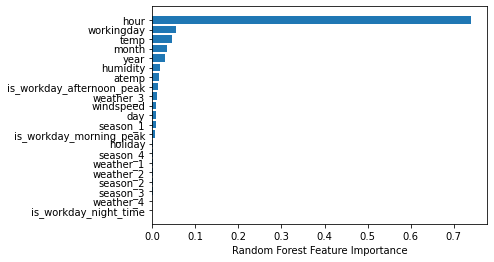

In [49]:
reg_4.feature_importances_
sorted_idx = reg_4.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], reg_4.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

The most critical feature is the hour of the day, followed by working days or not, temperature, month, year, and humidity.

Among the artificially added features, the importance of is_workday_afternoon_peak ranks first.

public score 0.449

In [50]:
from sklearn.model_selection import train_test_split
X = data_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
y = data_model['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19960127)
y_log_transformed = np.log1p(data_model['count'])
X_train, X_test, y_train, y_test = train_test_split(X, y_log_transformed, test_size=0.2, random_state=19960127)
xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,verbose = 0)
xgb.fit(X_train, y_train)
y_pred = list(xgb.predict(X_test))
y_pred_exp = np.expm1(y_pred) 
y_real = np.expm1(y_test)
cal_rmlse(y_real,y_pred_exp)

[14:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.29636364771874857

public score 0.456

---

# Submit to Kaggle

https://www.kaggle.com/competitions/bike-sharing-demand/submit

In [51]:
test_model = data[data['is_train'] == 0].reset_index(drop = True)
len(test_model)

6493

In [52]:
pred_data = test_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]

pred_log= list(reg_4.predict(pred_data))
#pred_log= list(rf_random.predict(pred_data))
#pred_log= list(xgb.predict(pred_data))
pred = np.expm1(pred_log)

output = test_model.copy()
output['count'] = pred
output = output[['datetime','count']]
output.tail()

,datetime,count
6488,2012-12-31 19:00:00,292.553066
6489,2012-12-31 20:00:00,220.589319
6490,2012-12-31 21:00:00,141.752467
6491,2012-12-31 22:00:00,123.254423
6492,2012-12-31 23:00:00,74.615014


In [53]:
output.to_csv('bike_demand_forecast.csv',index = False)

In [54]:
pd.read_csv('bike_demand_forecast.csv').head()

,datetime,count
0,2011-01-20 00:00:00,10.424311
1,2011-01-20 01:00:00,5.672816
2,2011-01-20 02:00:00,3.813489
3,2011-01-20 03:00:00,3.065031
4,2011-01-20 04:00:00,2.584771


---

# V. Predict casual + registered respectively then add up as count


## Step I. log transform casual + register

## Step II. train 2 models to predict casual & registered respectively

## Step III. mutate column count = casual + registered

## Step IV. evaluate result

In [55]:
# prepare train / test data
train_seperate = pd.read_csv('train.csv')
test_seperate = pd.read_csv('test.csv')
test_seperate['casual'] = 0
test_seperate['registered'] = 0
test_seperate['count'] = 0
train_seperate['is_train'] = 1
test_seperate['is_train'] = 0

train_seperate = data_process(train_seperate).complete_wrangling()
test_seperate = data_process(test_seperate).complete_wrangling()

data_model_seperate = train_seperate.append(test_seperate).reset_index(drop = True)

# use predicted windspeed to replace 0 in data
dataWind0 = data_model_seperate[data_model_seperate["windspeed"]==0]
dataWindNot0 = data_model_seperate[data_model_seperate["windspeed"]!=0]
rfModel_wind = RandomForestRegressor(random_state=19960127)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data_model_imputed_seperate = dataWindNot0.append(dataWind0)
data_model_imputed_seperate.reset_index(inplace=True)
data_model_imputed_seperate.drop('index',inplace=True,axis=1)

/var/folders/nr/yx9j5bns6rsdkxq34wbkwm2c0000gn/T/ipykernel_8649/337879554.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0["windspeed"] = wind0Values


In [56]:
data_model_seperate = data_model_imputed_seperate[data_model_imputed_seperate['is_train'] == 1].reset_index(drop = True)
train_indices = np.ones(len(data_model_seperate))
test_perc = 0.8
test_cutoff = int(len(data_model_seperate) * test_perc)
train_indices[:test_cutoff] = 0
np.random.seed(19960127)
np.random.shuffle(train_indices)
len(train_indices)
collections.Counter(train_indices)

Counter({0.0: 8708, 1.0: 2178})

In [57]:
data_model_seperate = data_model_imputed_seperate[data_model_imputed_seperate['is_train'] == 1].reset_index(drop = True)

data_model_seperate['is_train'] = train_indices
data_model_seperate['casual_log'] = np.log1p(data_model_seperate['casual'])

X_train = data_model_seperate[data_model_seperate['is_train'] == 1][['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
X_test = data_model_seperate[data_model_seperate['is_train'] == 0][['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
    
y_train = data_model_seperate[data_model_seperate['is_train'] == 1]['casual_log']
y_test = data_model_seperate[data_model_seperate['is_train'] == 0]['casual_log']

xgb_casual = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_casual.fit(X_train, y_train)
y_pred = list(xgb_casual.predict(X_test))
y_pred_exp = np.expm1(y_pred) 
y_pred_exp_casual = [p if p > 0 else 0 for p in y_pred_exp] # it is because predicted contains value < 0
y_real_casual = np.expm1(y_test) 
cal_rmlse(y_real_casual,y_pred_exp_casual)


0.5368516833282772

In [58]:
data_model_seperate = data_model_imputed_seperate[data_model_imputed_seperate['is_train'] == 1].reset_index(drop = True)
data_model_seperate['is_train'] = train_indices
data_model_seperate['registered_log'] = np.log1p(data_model_seperate['registered'])

X_train = data_model_seperate[data_model_seperate['is_train'] == 1][['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
X_test = data_model_seperate[data_model_seperate['is_train'] == 0][['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]
    
y_train = data_model_seperate[data_model_seperate['is_train'] == 1]['registered_log']
y_test = data_model_seperate[data_model_seperate['is_train'] == 0]['registered_log']

xgb_registered = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_registered.fit(X_train, y_train)
y_pred = list(xgb_registered.predict(X_test))
y_pred_exp = np.expm1(y_pred) 
y_pred_exp_registered = [p if p > 0 else 0 for p in y_pred_exp] 
y_real_registered = np.expm1(y_test) 
cal_rmlse(y_real_registered,y_pred_exp_registered)


0.34871120046646

In [59]:
y_real_total = data_model_seperate[data_model_seperate['is_train'] == 0]['count']
y_pred_total = [casual + registered for casual, registered in zip(y_pred_exp_casual, y_pred_exp_registered)]
cal_rmlse(y_real_total,y_pred_total)

0.34477568284713705

# VI. Submit to kaggle

In [60]:
test_model = data_model_imputed_seperate[data_model_imputed_seperate['is_train'] == 0].reset_index(drop = True)
pred_data = test_model[['holiday', 'workingday','hour','month','day','year',
          'temp', 'atemp', 'humidity', 'windspeed','season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'is_workday_morning_peak', 'is_workday_afternoon_peak',
       'is_workday_night_time']]

#pred_log= list(reg_4.predict(pred_data))
#pred_log= list(rf_random.predict(pred_data))
#pred_log= list(xgb.predict(pred_data))
pred_log = [np.expm1(casual) + np.expm1(registered) for casual, registered in zip(list(xgb_casual.predict(pred_data)), list(xgb_registered.predict(pred_data)))]

output = test_model.copy()
output['count'] = pred_log
output = output[['datetime','count']]
output.tail()

,datetime,count
6488,2012-12-29 12:00:00,63.437908
6489,2012-12-29 13:00:00,73.002151
6490,2012-12-29 15:00:00,177.013672
6491,2012-12-29 23:00:00,42.744392
6492,2012-12-30 19:00:00,226.080475


In [61]:
output.to_csv('bike_demand_forecast.csv',index = False)

In [62]:
pd.read_csv('bike_demand_forecast.csv').head()

,datetime,count
0,2011-01-20 00:00:00,15.700301
1,2011-01-20 03:00:00,2.270477
2,2011-01-20 04:00:00,2.307276
3,2011-01-20 05:00:00,5.295780
4,2011-01-20 06:00:00,44.165880


public score 0.448

---

# References

EDA & Feature Imputation:

https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile#Filling-0's-In-windspeed-Using-Random-Forest


Model testing & Parameter tuning :

https://www.kaggle.com/code/rajmehra03/bike-sharing-demand-rmsle-0-3194/notebook#THE-END.-[please-star/upvote-if-u-find-it-helpful.]

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74



Seperate count prediction by casual & register:

https://github.com/qinhanmin2014/kaggle-bike-sharing-demand/blob/master/GBDT_RF.ipynb